# Elementos de redes neuronales

```{margin}
*Como prerrequisitos para esta lección, sugiero leer la [lección anterior](https://dantenoguez.github.io/Ensayos/elementos-program.html) y el artículo de Khan Academy sobre la [pendiente matemática](https://es.khanacademy.org/math/cc-eighth-grade-math/cc-8th-linear-equations-functions/8th-slope/a/slope-from-two-points).*
```

Este ensayo está inspirado en [micrograd](https://github.com/karpathy/micrograd) de Andrej Karpathy. A continuación, construiremos una red neuronal desde cero, explicando a detalle cada uno de sus elementos.

In [ ]:
!pip install matplotlib --upgrade

In [1]:
import matplotlib.pyplot as plt
import numpy as np

### La derivada

```{margin}
Recomiendo mirar [este video](https://es.khanacademy.org/math/ap-calculus-ab/ab-differentiation-1-new/ab-2-1/v/newton-leibniz-and-usain-bolt) antes de continuar la lectura.
```

Las redes neuronales son gigantescas expresiones matemáticas realizando operaciones iterativamente. El proceso de «aprendizaje» de una red neuronal consiste en afinar ciertos números que la componen para lograr un patrón de «entendimiento». Tal proceso de aprendizaje es un elemento constitutivo en todo modelo de *deep learning* (en el habla común, quien hoy dice inteligencia artificial casi siempre se refiere al *deep learning* o «aprendizaje automático»).

Hablemos de dicho método de aprendizaje para luego poder avanzar a una visión más holística. El proceso de aprendizaje en una red neuronal se da a través de la derivada. Procuremos entenderla: conceptualmente, la derivada es muy similar a la pendiente, y mide la **proporción o magnitud del cambio** que una variable provoca en el resultado de una función. Digamos que la derivada mide la fuerza con la que una variable influye en el resultado de una función.

Como ejemplo, midamos el cambio que una variable $a$ (con valores del 0 al 12 en intervalos de 2) provoca en el resultado de una función $c$ (equivalente a multiplicar $a$ por $b$, donde $b$ siempre tiene un valor de 5):

$$
\text{Función} \ c(a) = ba
$$

Por ejemplo, un valor de la función sería $c(a) = 5 \times 2$, y así sucesivamente:

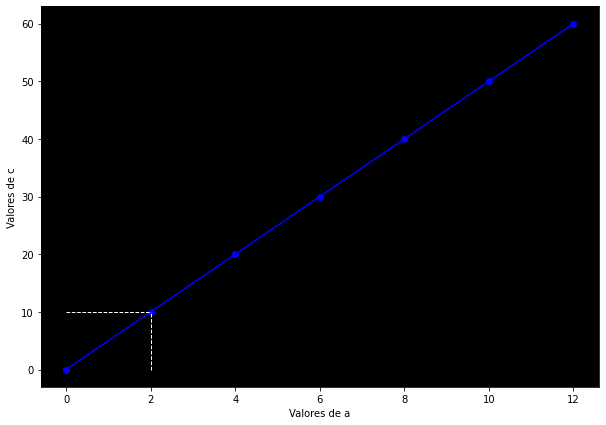

In [2]:
a = np.arange(0, 13, 2) 
b = 5
def f(a, b): return a*b
c = f(a, b)

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(a, c, marker='o', color='blue') 
ax.set_facecolor('black')
ax.set_xlabel('Valores de a')
ax.set_ylabel('Valores de c')
ax.hlines(y=10, xmin=0, xmax=2, linewidth=1, color='white', linestyles='dashed')
ax.vlines(x=2, ymin=0, ymax=10, linewidth=1, color='white', linestyles='dashed')
plt.show()

Nuestras correspondencias lucen así:

In [3]:
import pandas as pd
d = {'Valores de a': a, 'Valores de b': b, 'Valores de c': c}
tabla = pd.DataFrame(data=d)
tabla = tabla.style.hide_index()
tabla

Valores de a,Valores de b,Valores de c
0,5,0
2,5,10
4,5,20
6,5,30
8,5,40
10,5,50
12,5,60


Lo que la derivada nos señala, como digo, es cuánto influye $a$ en el valor de $c$: si yo paso del primer al segundo valor de $a$, es decir, si paso de 0 a 2, ¿cuánto aumenta $c$? $c$ aumenta 5 veces $a$. Si doy otro paso en $a$, es decir, si paso de 2 a 4. ¿cuánto aumenta $c$? Nuevamente, $b$ aumenta 5 veces $a$: $4 \times 5 = 20$. Intuitivamente: dado que $c$ es el resultado de multiplicar 5 veces $a$, es claro que cada valor de $c$ será cinco veces más grande que cada valor correspondiente de $a$.

Así, la derivada[^1] de la función $c$ con respecto a $a$ es 5. 5 es la proporción con la que $c$ está cambiando; 5 es la «fuerza» con la que $a$ está influyendo en el resultado de $c$. Es como si no supiéramos que $a$ está siendo multiplicado por $b$ para resultar $c$, y entonces aplicáramos nuestro razonamiento matemático para deducirlo. 

Visualicémoslo:

Valores de la derivada en cada punto: [5. 5. 5. 5. 5. 5. 5.]


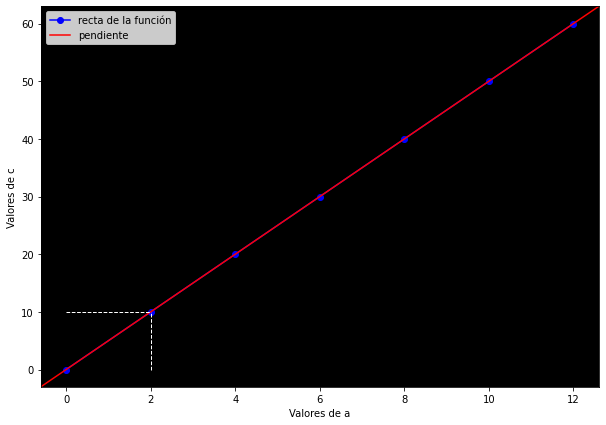

In [4]:
deriv = (f(a+0.00001, b) - f(a, b)) / 0.00001
print(f'Valores de la derivada en cada punto: {deriv}')

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(a, c, marker='o', color='blue', label='recta de la función') 
ax.set_facecolor('black')
ax.set_xlabel('Valores de a')
ax.set_ylabel('Valores de c')
ax.axline((a[1], c[1]), slope=deriv[1], color='red', label='pendiente') # <- La pendiente es la derivada
ax.hlines(y=10, xmin=0, xmax=2, linewidth=1, color='white', linestyles='dashed')
ax.vlines(x=2, ymin=0, ymax=10, linewidth=1, color='white', linestyles='dashed')
ax.legend()
plt.show()

```{margin}
En una función no lineal nunca hablamos de la pendiente de la función, sino de la pendiente de la tangente a un punto (que equivale a la derivada). Aun así, en términos conceptuales, cuando hablamos de dos dimensiones, derivada y pendiente son similares y la comparación puede ayudar a entender la derivada.
```

La línea tangente al punto con respecto al que se deriva (denotado por las líneas punteadas: $a=2, c=10$) resulta tener la misma inclinación que la recta de la función. Geométricamente, en espacios de dos dimensiones, podríamos entender a la derivada como el grado de inclinación de la línea tangente a un punto de la función. Pero dado que todos los puntos de una función lineal (o sea, una recta) tienen la misma inclinación, entonces la inclinación de la tangente es la misma que la de la recta y, consecuentemente, la derivada es igual a la pendiente.

En suma, la pendiente y la derivada tienen el mismo valor porque la proporción que guardan los valores de la variable $a$ y la función $c$ es la misma en todos los puntos: la inclinación de la recta nos la dieron los valores de $a$ y $c$; la proporción entre ellos se ve reflejada en la inclinación; y dicha inclinación representa la «fuerza» con la que $a$ influye en $c$ «a través del tiempo», es decir, conforme pasamos de un valor de $a$ al siguiente.

Pongamos otro ejemplo: si los valores de la función nunca cambiaran, entonces su derivada sería 0. Geométricamente, no habría nada de inclinación en la tangente; conceptualmente, la definición de la función indicaría que su resultado nunca cambiará: ninguna variable tendría influencia en la función, de manera que el «cambio» siempre sería nulo, cero.

Supongamos que quiero medir la distancia que recorro en 20 segundos: si con el paso del tiempo no avanzo nada o, lo que es lo mismo, si la variable tiempo no influye en la función distancia, entonces la función, la pendiente y la tangente a cualquier punto lucen así:

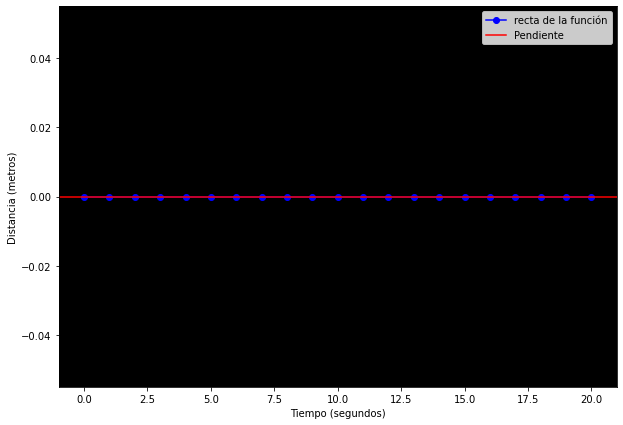

In [5]:
tiempo = np.arange(0, 21, 1)
def f(t): return t*0
distancia = f(tiempo)

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(tiempo, distancia, marker='o', color='blue', label='recta de la función') 
ax.set_facecolor('black')
ax.set_xlabel('Tiempo (segundos)')
ax.set_ylabel('Distancia (metros)')
ax.axline((tiempo[0], distancia[0]), slope=0, color='red', label='Pendiente')
ax.legend()
plt.show()

Veamos otro ejemplo, ahora con la función suma: mi variable $x$ tendrá valores del 0 al 12 con intervalos de 2, mientras que mi función es $x+6$. Mi tabla de valores entonces debería quedar así:

In [6]:
x = np.arange(0, 13, 2)
def f(x): return x+6
y = f(x)

z = {'Valores de x': x, 'Valores de y': y}
tabla = pd.DataFrame(data=z)
tabla = tabla.style.hide_index()
tabla

Valores de x,Valores de y
0,6
2,8
4,10
6,12
8,14
10,16
12,18


Ahora preguntémonos: ¿en qué proporción cambia $y$ cuando aumentamos $x$? Si paso de mi primer valor de $x$ al segundo, es decir, si paso de 0 a 2, ¿cuánto estoy aumentando a mi primer valor de $y$? ¡También dos! Es decir, que la proporción de los cambios entre $x$ e $y$ es 1: si aumento dos a $x$, también aumento 2 a $y$. En nuestro primer ejemplo, si agregábamos 2 a $a$, nuestro valor de $c$ aumentaba cinco veces $a$.

Esto tiene sentido porque la multiplicación aumenta nuestros valores con mayor velocidad y en diferente proporción que la suma: por ejemplo, $2 \times 4 = 8$, pero $2 + 4 = 6$, y conforme tomamos números más grandes, nuestra multiplicación continúa creciendo a mayor velocidad que la suma: $2 \times 10 = 20$, pero $2 + 10 = 12$.

Grafiquemos nuestra nueva función de suma:

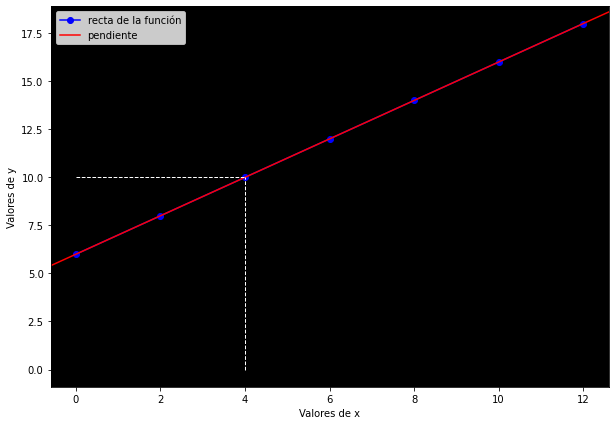

In [7]:
derivada = (y[2] - y[1]) / (x[2] - x[1])

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(x, y, marker='o', color='blue', label='recta de la función') 
ax.set_facecolor('black')
ax.set_xlabel('Valores de x')
ax.set_ylabel('Valores de y')
ax.axline((x[1], y[1]), slope=derivada, color='red', label='pendiente')
ax.hlines(y=10, xmin=0, xmax=4, linewidth=1, color='white', linestyles='dashed')
ax.vlines(x=4, ymin=0, ymax=10, linewidth=1, color='white', linestyles='dashed')
ax.legend()
plt.show()

La inclinación de la recta es menor porque $y$ aumenta lentamente en proporción a $x$, de 2 en 2. Una vez más: únicamente estamos averiguando la proporción que hay entre los valores de $x$ y de $y$. Si cada valor de $x$ aumenta significativamente cada valor correspondiente de la función, entonces nuestra derivada será alta y la inclinación de la recta será empinada. 

Por otra parte, cuando cada valor de la función aumenta poco conforme hacemos más grande nuestra variable de entrada, entonces la derivada será pequeña y la inclinación será poca.

Veamos, por último, una función no lineal para distinguir claramente la tangente de la gráfica con una inclinación (pendiente) equivalente a la derivada. Esta función no tiene pendiente porque no es una recta:

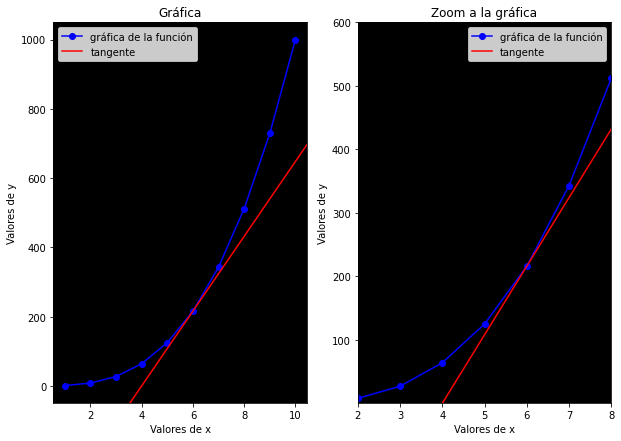

In [38]:
xs = np.arange(1, 11, 1)
def cub(x): return x**3
y = cub(xs)

derivs = (cub(xs+0.00001) - cub(xs)) / 0.00001

fig, ax = plt.subplots(ncols=2, figsize=(10, 7))
ax[0].plot(xs, y, marker='o', color='blue', label='gráfica de la función')
ax[0].set_title('Gráfica')
ax[0].set_facecolor('black')
ax[0].set_xlabel('Valores de x')
ax[0].set_ylabel('Valores de y')
ax[0].axline((xs[5], y[5]), slope=derivs[5], color='red', label='tangente')
ax[0].legend()
ax[1].plot(xs, y, marker='o', color='blue', label='gráfica de la función') 
ax[1].set_title('Zoom a la gráfica')
ax[1].set_facecolor('black')
ax[1].set_xlabel('Valores de x')
ax[1].set_ylabel('Valores de y')
ax[1].axline((xs[5], y[5]), slope=derivs[5], color='red', label='tangente')
ax[1].set_xlim(xs[1], xs[7])
ax[1].set_ylim(y[0], 600)
ax[1].legend()
plt.show()

En este último caso, la proporción entre $x$ y el resultado de la función nos la da la fórmula $y = zx^{z-1}$. Por ejemplo, la derivada con respecto al punto a partir del cual trazamos la tangente anterior se puede calcular así:

$$
3x^{3-1}
$$

$$
x = 6
$$

$$
3(6^2) = 3(36) = 108
$$

¿De dónde sale esa fórmula? Podemos obtenerla razonando lógicamente como lo hicimos con los ejemplos anteriores, o analíticamente, es decir, empleando métodos lógico-matemáticos más definidos que utilizan los académicos para estudiar, desarrollar y explorar estos temas. Este último caso requiere cierto entrenamiento técnico, pero aunque más complejo, es prácticamente el mismo que el que hemos utilizado.

Ahora, revisemos una definición matemática de la derivada. La fórmula se puede escribir así:

$$
f^{\prime}(x)=\lim _{h \rightarrow 0} \frac{f(x+h)-f(x)}{h}
$$

Mientras que la fórmula de una deriva parcial es:

$$
\frac{\partial f(x, y)}{\partial x}=\lim _{h \rightarrow 0}{\frac{f(x+h, y)-f(x, y)}{h}}
$$

```{margin}
Sobre límites se puede leer [este artículo](https://es.khanacademy.org/math/ap-calculus-ab/ab-limits-new/ab-1-2/a/limits-intro?modal=1); sobre derivadas, [estos videos](https://es.khanacademy.org/math/ap-calculus-ab/ab-differentiation-1-new).
```

Por una parte, es importante familiarizarnos con la notación matemática, así podremos identificar estos conceptos y fórmulas en los textos académicos. El signo $\partial$ es la letra «d» cursiva y se utiliza para abreviar «derivada [parcial]», por lo que la segunda fórmula equivale a «derivada parcial de $f$ con respecto a $x$». El símbolo $\lim _{h \rightarrow 0}$ significa «el límite de la función cuando $h$ tiende a 0». A efectos prácticos, este símbolo indica que al momento de aplicar la fórmula, debemos reemplazar $h$ por un valor cercano a 0.

Ambas fórmulas significan lo mismo. Si prestamos atención, ambas realizan una resta para medir el impacto de una variable en la función, y después una división para estimar la proporción de dicho cambio. En Wikipedia, se define a la derivada de una función como una «razón de cambio instantánea con la que varía el valor de dicha función matemática, según se modifique el valor de su variable independiente». En otras palabras, es lo que decíamos: la derivada mide la proporción (o razón, o tasa, o magnitud) del cambio que una variable provoca en la función.

### Pero ¿para qué sirve la derivada?

Imaginemos que tenemos dos variables: $x = -2$ e $y = 3$. La función $f(x, y)$ las multiplica y su resultado es $-6$. Sin embargo, queremos alterar ese resultado para que sea $0$ y tenemos una restricción: la única manera de hacerlo es a través de las variables de entrada. Para ello, podríamos pensar en aumentar o disminuir las entradas en pasos pequeños y probar aleatoriamente hasta conseguir el resultado.

```{margin}
Ojo: disminuir el 3 aumenta el resultado, puesto que está siendo multiplicado por un número negativo. Ejemplo: 3-1 = 2, 2*-2 = -4, y -4 es mayor que -6, el resultado inicial.
```
Supongamos que nuestro cambio aplicado será $0.01$: disminuiremos $y$ en esa cantidad y aumentaremos $x$ de la misma forma: $x = -1.99 \times y = 2.99 = -5.95$. Bien, $-5.95$ es más cercano a $0$ que $-6$. Podríamos continuar este proceso hasta llegar a $0$, pero nuestro método no parece muy efectivo.

Si recordamos la lección aprendida en las derivadas, se nos puede ocurrir utilizarlas para resolver este problema: dado que la derivada me dice el impacto que tiene una variable de entrada en la función, ¿será posible utilizarla para alterar el resultado de la función? Es decir, si la derivada me dice la magnitud del impacto que una varible tiene en el resultado, entonces debería poder utilizar esa información para influir en el resultado de manera más eficiente. Por ejemplo, si la derivada me indica que una variable influye positivamente en la función, pero yo quiero disminuirla, entonces sabré más o menos la magnitud en que debo disminuir esa variable, y así sucesivamente.

### Pequegrad

Para entender mejor la posible solución planteada, crearemos programáticamente la clase `Numero`, es decir, formularemos una estructura que nos permita definir, modificar y operar con números. De momento, cada `Numero` tendrá las siguientes propiedades: un `valor`, un par de valores `previos` para el caso de que el `valor` haya sido generado mediante una operación (por ejemplo, 2 y 2 en el caso de que multiplicados hayan generado el número 4), la `operación` que generó dicho valor (en nuestro ejemplo, la multiplicación) y una etiqueta en caso de que queramos asociar nuestro `valor` a una variable. Por ahora, únicamente tendremos las operaciones de suma, multiplcación, resta y división:

In [60]:
class Numero:
  def __init__(self, valor, _previos=(), _op='', etiqueta=''):
    self.valor = valor
    self._previos = set(_previos)
    self._op = _op
    self.etiqueta = etiqueta

  def __add__(self, otro): # adición
    otro = otro if isinstance(otro, Numero) else Numero(otro) # nos cercioramos de que el otro valor sea un Número
    resultado = Numero(self.valor + otro.valor, (self, otro), '+')
    return resultado

  def __radd__(self, otro): 
    return self + otro

  def __mul__(self, otro): # multiplicación
    otro = otro if isinstance(otro, Numero) else Numero(otro)
    resultado = Numero(self.valor * otro.valor, (self, otro), '*')
    return resultado

  def __rmul__(self, otro):
    return self * otro

  def __sub__(self, otro): # resta, substracción
    return self + (-otro)

  def __truediv__(self, otro): # división
    return self * otro**-1 #dividir es lo mismo que multiplicar por el dividendo elevado a la menos 1
  
  def __rtruediv__(self, otro):
    return otro * self**-1

  def __neg__(self): # volver negativo un número
    return self * -1

  def __repr__(self):
    return f'Valor={self.valor}' # esta función determina cómo se representa nuestro número

Utilizaremos un problema más desafiante que una simple multiplicación:

In [61]:
# Definimos la función L con los siguientes números y operaciones:

a = Numero(-2.0, etiqueta='a')
b = Numero(3.0, etiqueta='b')
c = a*b; c.etiqueta = 'c' # definimos c, que es el resultado de multiplicar a y b
d = Numero(10.0, etiqueta='d')
e = c + d; e.etiqueta = 'e'
f = Numero(-3.0); f.etiqueta = 'f'
L = f * e; L.etiqueta= 'L'

print(f'Ejemplo: Valor de c: {c} | Valores previos: {c._previos} | Operación realizada para generar c: {c._op}')

Ejemplo: Valor de c: Valor=-6.0 | Valores previos: {Valor=3.0, Valor=-2.0} | Operación realizada para generar c: *


```{margin}
El código para graficar no tiene que ver con las redes neuronales, de manera que queda fuera de nuestro enfoque explicarlo.
```

También crearemos una función para graficar nuestras operaciones:

In [62]:
from graphviz import Digraph

def rastreo(origen):
  # construye un conjunto de todos los nodos en un gráfico
  nodos, lineas = set(), set()
  def construir(v):
    if v not in nodos:
      nodos.add(v)
      for parte in v._previos:
        lineas.add((parte, v))
        construir(parte)
  construir(origen)
  return nodos, lineas

def graficar(origen):
  grafica = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # left to right, izquierda a derecha

  nodos, lineas = rastreo(origen)
  for n in nodos:
    uid = str(id(n))
    # por cada valor en la gráfica, crea un nodo rectangular ('record') para él
    grafica.node(name=uid, label='{ %s | valor %.4f}' % (n.etiqueta, n.valor), shape='record')
    if n._op:
      # si el valor es resultado de una operación, crea un nodo para la operación
      grafica.node(name = uid + n._op, label = n._op)
      # conecta los nodos
      grafica.edge(uid + n._op, uid)

  for n1, n2 in lineas:
    # conecta n1 al nodo operación de n2
    grafica.edge(str(id(n1)), str(id(n2)) + n2._op)

  return grafica

Finalmente, visualizamos la función[^2]. El problema a resolver consiste en influir en los valores de la función $L$ para llevarla a 0.

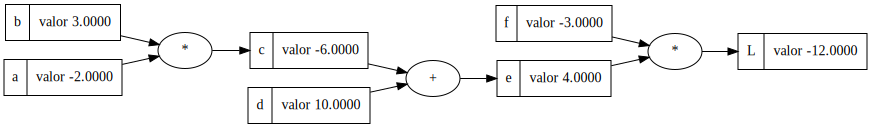

In [63]:
graficar(L)

Como decíamos, intuitivamente creemos que la derivada puede ayudarnos: con la derivada sabemos qué impacto tiene cada variable en el resultado final $L$. En ese sentido, lo que tendremos que hacer primero es calcular la derivada de $L$ con respecto a cada variable.

En principio, la derivada de $L$ con respecto a sí misma es 1: aunque suene absurdo y evidente a la vez, el cambio en $L$ es proporcional (idéntico) a sí mismo. Ahora, la derivada de $L$ con respecto a $f$ y $e$ la podemos averiguar con la fórmula que veníamos utilizando:

In [64]:
def derivada():
  h = 0.000001

  # Función original
  a = Numero(-2.0, etiqueta='a')
  b = Numero(3.0, etiqueta='b')
  c = a*b; c.etiqueta = 'c'
  d = Numero(10.0, etiqueta='d')
  e = c + d; e.etiqueta = 'e'
  f = Numero(-3.0); f.etiqueta = 'f'
  L1 = f * e; L.etiqueta= 'L1'

  # Función con incremento h
  a = Numero(-2.0, etiqueta='a')
  b = Numero(3.0, etiqueta='b')
  c = a*b; c.etiqueta = 'c'
  d = Numero(10.0, etiqueta='d')
  e = c + d; e.etiqueta = 'e'
  e.valor += h # aumento de h para obtener la derivada de L con respecto a e
  f = Numero(-3.0); f.etiqueta = 'f'
  L2 = f * e; L.etiqueta= 'L2'

  print((L2 - L1) / h) # fórmula de la derivada

derivada()

Valor=-2.9999999995311555


La derivada de la función $L$ con respecto a $e$ es aproximadamente $-3$. A estas alturas, ya habremos notado un patrón: cuando derivamos una multiplicación, la derivada parcial con respecto al multiplicando es el multiplicador. En este caso, $L$ es el resultado de multiplicar $e$ con $f$. Vimos que la derivada con respecto a $e$ es $-3$, o sea $f$. Podemos inducir, empíricamente y por simetría, que la derivada con respecto a $f$ es $e$, o sea 4.

Quizá también sea una buena oportunidad para demostrar analíticamente lo que venimos diciendo. Utilizando nuestra fórmula matemática, tenemos que:

$$
\frac{\partial L(e, f)}{\partial e}=\lim _{h \rightarrow 0}{\frac{L(e + h, f)-L(e, f)}{h}} = {\frac{(e + h) \cdot f - e \cdot f}{h}} = {\frac{ef + hf - ef}{h}} = {\frac{hf}{h}} = f
$$

Y aunque la notación aparente complejidad, en realidad solo estamos sumando, multiplicando, restando y dividiendo.

Ahora que ya tenemos esta información, queremos continuar al nodo anterior: las derivadas con respecto a $c$ y $d$. Pero aquí hay una sutileza que, bien entendida, nos dará la clave de las redes neuronales: debemos obtener la derivada de $L$ con respecto a $c$ y $d$, no la derivada de $e$ con respecto a ellas. Entonces, ¿cómo podemos averiguar el impacto que $c$ y $d$ tienen en $L$ a través de $e$? Para hacer este cálculo solo hace falta una intuición bastante simple.

### La regla de la cadena: propagación hacia atrás
Tomemos prestada la analogía de George Simmons: si una bicicleta es dos veces más rápida que una persona corriendo, y un automóvil cuatro veces más rápido que una bicicleta, entonces el automóvil es $2 \times 4 = 8$ veces más rápido que una persona corriendo.

De igual forma, si queremos saber la influencia que $c$ tiene en $L$, solo debemos obtener la derivada de $e$ con respecto a $c$, y multiplicarla por la derivada de $L$ con respecto a $e$. Es decir, debemos multiplicar la fuerza de $c$ en $e$ y la de $e$ en $L$ para saber con cuánta fuerza influye $c$ en $L$. Lo mismo vale para $d$ y todas las demás; a esta regla se le llama «regla de la cadena» (y mediante ella se realiza la «propagación hacia atrás» en el campo de la inteligencia artificial).

Ahora, para obtener la derivada de $e$ con respecto a $c$, recordemos otro patrón que vimos: en una suma, la derivada nos daba como resultado $1$ porque la función avanzaba en la misma proporción que avanzaba la variable. Verifiquémoslo:

In [65]:
def deriv_e(c, d):
  return (((c+0.00001)+d) - (c+d)) / 0.00001

deriv_e(-6, 10)

0.9999999999621422

En efecto, el resultado es aproximadamente 1. Por simetría nuevamente, entendemos que la derivada de $e$ con respecto a $d$ también es $1$.

Y ahora que ya tenemos ambas derivadas, podemos multiplicarlas: $1 \times -3 = -3$. Así pues, la derivada de $L$ con respecto a $c$ y $d$ es $-3$. En términos matemáticos, hemos hecho algo equivalente a:

$$
\frac{dz}{dx} = \frac{dz}{dy} \cdot \frac{dy}{dx}
$$

Donde $z$ depende de $y$ y, a su vez, $y$ depende de $x$.

Comprobémoslo programáticamente:

In [66]:
def derivada():
  h = 0.000001

  # Función original
  a = Numero(-2.0, etiqueta='a')
  b = Numero(3.0, etiqueta='b')
  c = a*b; c.etiqueta = 'c'
  d = Numero(10.0, etiqueta='d')
  e = c + d; e.etiqueta = 'e'
  f = Numero(-3.0); f.etiqueta = 'f'
  L1 = f * e; L.etiqueta= 'L1'

  # Función con incremento h
  a = Numero(-2.0, etiqueta='a')
  b = Numero(3.0, etiqueta='b')
  c = a*b; c.etiqueta = 'c'
  c.valor += h # aumento de h para obtener la derivada de L con respecto a c
  d = Numero(10.0, etiqueta='d')
  e = c + d; e.etiqueta = 'e'
  f = Numero(-3.0); f.etiqueta = 'f'
  L2 = f * e; L.etiqueta= 'L2'

  print((L2 - L1) / h) # fórmula de la derivada

derivada()

Valor=-2.9999999995311555


Finalmente, debemos hacer lo mismo para obtener las derivadas con respecto a $a$ y $b$. Entonces, dado el patrón que habíamos descubierto, la derivada de $c$ con respecto a $a$ es $b$, o sea $3$, y viceversa: la derivada con respecto a $b$ es $a$, o sea $-2$. Pero recordemos: estas derivadas «locales» son de la función $c$, y a nosotros nos interesa la derivada de $L$, es decir, la magnitud de la influencia que $a$ y $b$ tienen en $L$. Para saberlo, nuevamente debemos aplicar la regla de la cadena y multiplicar las derivadas que tenemos por la derivada de $L$ con respecto a $c$. Entonces, la derivada parcial de $L$ con respecto a $a$ es $3 \times -3 = -9$, mientras que la derivada parcial con respecto a $b$ es $-2 \times -3 = 6$.
```{margin}
A la derivada global, es decir, a la que se da con respecto al resultado final y no al local, se le denomina «gradiente». Las fórmulas que utilizamos para derivar pueden leerse [aquí](https://es.wikipedia.org/wiki/Derivada#Cálculo_de_la_derivada); algunas fórmulas que utilizaremos a continuación, [aquí](https://aew61.github.io/blog/artificial_neural_networks/1_background/1.b_activation_functions_and_derivatives.html).
```

Ahora que ya tenemos estos valores, podemos optimizar nuestro código para contemplarlos y visualizarlos de mejor manera. Añadiremos también algunas funciones que después detallaremos. En la práctica, nadie calcula las derivadas manualmente como lo hicimos, puesto que sería una labor eterna; pero ya hemos aprendido los patrones para calcularlas, así que podemos implementarlos en nuestro código para que se calculen automáticamente:

In [121]:
import math

class Numero:
  def __init__(self, valor, _previos=(), _op='', etiqueta=''):
    self.valor = valor
    self.grad = 0.0 # gradiente, comienza en 0
    self._propagar = lambda: None # el valor predeterminado de la propagación hacia atrás es nulo
    self._previos = set(_previos)
    self._op = _op
    self.etiqueta = etiqueta

  def __add__(self, otro): 
    otro = otro if isinstance(otro, Numero) else Numero(otro) 
    resultado = Numero(self.valor + otro.valor, (self, otro), '+')

    def _propagar():
      self.grad += 1.0 * resultado.grad # la derivada de una suma es 1; después, se multiplica por la «derivada global»
      otro.grad += 1.0 * resultado.grad
    resultado._propagar = _propagar

    return resultado

  def __radd__(self, otro): 
    return self + otro

  def __mul__(self, otro):
    otro = otro if isinstance(otro, Numero) else Numero(otro)
    resultado = Numero(self.valor * otro.valor, (self, otro), '*')

    def _propagar():
      self.grad += otro.valor * resultado.grad # la derivada de la multiplicación es igual al multiplicando por la derivada global
      otro.grad += self.valor * resultado.grad
    resultado._propagar = _propagar

    return resultado

  def __rmul__(self, otro):
    return self * otro

  def __pow__(self, otro): # potenciación
    assert isinstance(otro, (int, float))
    resultado = Numero(self.valor**otro, (self,), f'**{otro}')

    def _propagar():
      self.grad += otro * (self.valor ** (otro - 1)) * resultado.grad # recordemos la fórmula: yx**y-1
    resultado._propagar = _propagar

    return resultado

  def __sub__(self, otro): 
    return self + (-otro)

  def __rsub__(self, otro):
    return otro + (-self)

  def __neg__(self): 
    return self * -1

  def __truediv__(self, otro): 
    return self * otro**-1 
  
  def __rtruediv__(self, otro):
    return otro * self**-1

  def ReLU(self): 
    resultado = Numero((0 if self.valor < 0 else self.valor), (self,), 'ReLU')

    def _propagar():
      self.grad += (1 if resultado.valor > 0 else 0) * resultado.grad # la derivada es 1 si x > 0, 0 si x < 0
    resultado._propagar = _propagar
    
    return resultado

  def tanh(self): # tangente hiperbólica
    t = (math.exp(2*self.valor) - 1) / (math.exp(2*self.valor) + 1)
    resultado = Numero(t, (self,), 'tanh')

    def _propagar():
      self.grad += (1 - t**2) * resultado.grad # según la fórmula 1-tanh**2x
    resultado._propagar = _propagar

    return resultado

  def sigmoide(self):
    s = 1/(1 + math.exp(self.valor))
    resultado = Numero(s, (self,), 'sigmoide')

    def _propagar():
      self.grad += (s * (1 - s)) * resultado.grad # la derviada es s(x)(1-s(x))
    resultado._propagar = _propagar

    return resultado

  def exp(self): # exponenciación
    resultado = Numero(math.exp(self.valor), (self,), 'exp')

    def _propagar():
      self.grad += self.valor * resultado.grad
    resultado._propagar = _propagar

    return resultado

  def log(self): # logaritmo natural
    resultado = Numero(math.log(self.valor), (self,), 'log')

    def _propagar():
      self.grad += 1/self.valor * resultado.grad
    resultado._propagar = _propagar

    return resultado

  def propagar(self):
    # ordenamiento topológico
    topo = []
    visitados = set()
    def construir_topo(v):
      if v not in visitados:
        visitados.add(v)
        for previo in v._previos:
          construir_topo(previo)
        topo.append(v)
    construir_topo(self)

    self.grad = 1 # asignamos la derivada del valor final con respecto a sí mismo: 1
    for nodo in reversed(topo): # comenzamos desde adelante hacia atrás
      nodo._propagar()

  def __repr__(self):
    return f'Valor={self.valor}'

In [122]:
from graphviz import Digraph

def rastreo(origen):
  nodos, lineas = set(), set()
  def construir(v):
    if v not in nodos:
      nodos.add(v)
      for parte in v._previos:
        lineas.add((parte, v))
        construir(parte)
  construir(origen)
  return nodos, lineas

def graficar(origen):
  grafica = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

  nodos, lineas = rastreo(origen)
  for n in nodos:
    uid = str(id(n))
    grafica.node(name=uid, label='{ %s | valor %.4f | grad %.4f}' % (n.etiqueta, n.valor, n.grad), shape='record')
    if n._op:
      grafica.node(name = uid + n._op, label = n._op)
      grafica.edge(uid + n._op, uid)

  for n1, n2 in lineas:
    grafica.edge(str(id(n1)), str(id(n2)) + n2._op)

  return grafica

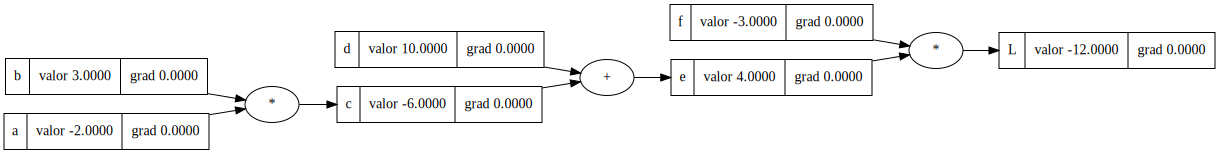

In [123]:
a = Numero(-2.0, etiqueta='a')
b = Numero(3.0, etiqueta='b')
c = a*b; c.etiqueta = 'c'
d = Numero(10.0, etiqueta='d')
e = c + d; e.etiqueta = 'e'
f = Numero(-3.0); f.etiqueta = 'f'
L = f * e; L.etiqueta= 'L'

graficar(L)

Ahora obtendremos las derivadas, pero programática en vez de manualmente:

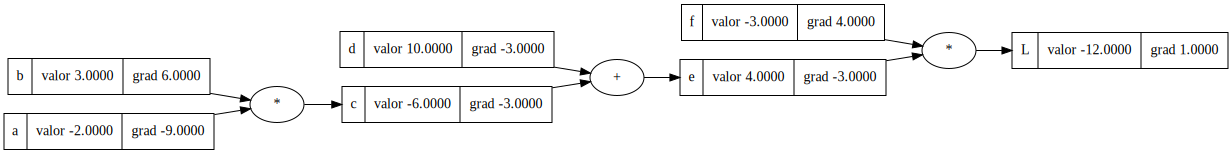

In [124]:
L.propagar()
graficar(L)

Bien. Ahora pongamos en práctica nuestra intuición: dado que el gradiente (o derivada global, o la colección de derivadas parciales de $L$ con respecto a cada variable) nos dice la «fuerza» con la que cada número aumenta el resultado final de la función, podemos utilizar esa misma fuerza para alterar nuestros valores y, con ello, aumentar el valor de $L$. La bondad de utilizar el gradiente es que nos indica la «dirección» y la magnitud en la que debemos modificar cada valor para aumentar el resultado final, es decir: aumentar el valor de cada variable en la misma dirección del gradiente, contribuye a elevar el valor de la función global. Incluso si el gradiente tiene un valor negativo, eso indicaría que el valor de la variable debe disminuir para incrementar la función. De igual forma, si lo que queremos es disminuir el valor de una función, solo debemos ir en la dirección opuesta —*i. e.*, negativa— al gradiente.

Las siguientes imágenes ilustran con flechas azules la dirección del gradiente, y en blanco y negro a los valores de la función (el negro indica los valores más altos). Como digo, el gradiente indica la dirección en la que la función aumenta su valor:

<img src='https://upload.wikimedia.org/wikipedia/commons/0/0f/Gradient2.svg' width=500>

Solo hace falta un detalle: al emplear esta estrategia, debemos ser cuidadosos de no excedernos en el aumento del resultado, puesto que queremos llegar a 0 sin superarlo. Para ello, podemos atenuar la fuerza de los gradientes, multiplicándolos por un número pequeño como 0.01 o 0.1 para luego sumar (en caso de querer aumentar el resultado final de la función) o restar ese valor a la variable. Probemos un ejemplo con la variable $a$:

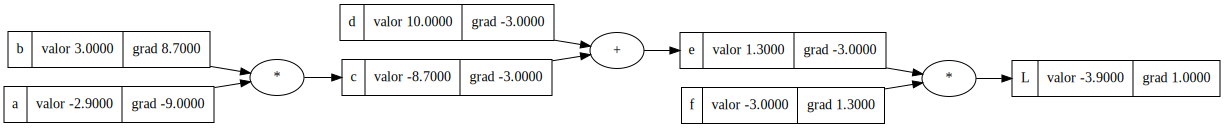

In [125]:
na = a + 0.1 * a.grad # nuevo valor de a: su derivada multiplicada por 0.1 + el valor anterior de a

a = Numero(na.valor, etiqueta='a') # asignamos el nuevo valor a la variable
b = Numero(3.0, etiqueta='b')
c = a*b; c.etiqueta = 'c'
d = Numero(10.0, etiqueta='d')
e = c + d; e.etiqueta = 'e'
f = Numero(-3.0); f.etiqueta = 'f'
L = f * e; L.etiqueta= 'L'

L.propagar()

graficar(L)

Bien, parece que nuestro método funciona. Sin embargo, comprobamos que quizá nuestra fuerza es elevada, puesto que disminuyó mucho el resultado. Probablemente tengamos un mejor resultado si hacemos esto con todas nuestras variables, pero con una fuerza más atenuada (0.01):

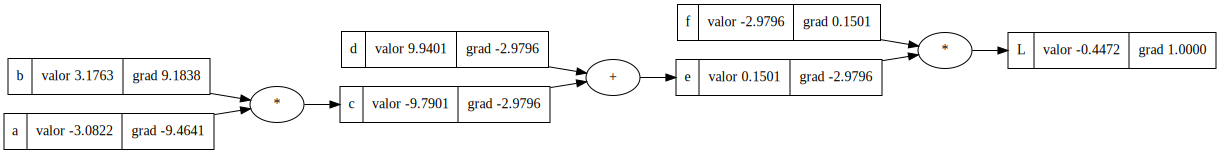

In [127]:
na = a + 0.01 * a.grad
nb = b + 0.01 * b.grad
nd = d + 0.01 * d.grad
nf = f + 0.01 * f.grad

a = Numero(na.valor, etiqueta='a')
b = Numero(nb.valor, etiqueta='b')
c = a*b; c.etiqueta = 'c'
d = Numero(nd.valor, etiqueta='d')
e = c + d; e.etiqueta = 'e'
f = Numero(nf.valor); f.etiqueta = 'f'
L = f * e; L.etiqueta= 'L'

L.propagar()

graficar(L)

Aunque no hayamos conseguido un resultado de exactamente 0, nos hemos aproximado significativamente con nuestro nuevo método programático. Pronto explotaremos el verdadero poder detrás de esta nueva herramienta nuestra, aunque desde ya podamos proclamar —con Françoise Hardy— ¡voilà! Esta es la esencia del aprendizaje en una red neuronal.

<iframe style="border-radius:12px" src="https://open.spotify.com/embed/track/4YIZP4nlw3jV5DkXGB56iG?utm_source=generator" width="100%" height="152" frameBorder="0" allowfullscreen="" allow="autoplay; clipboard-write; encrypted-media; fullscreen; picture-in-picture" loading="lazy"></iframe>

---

```{margin}
*Bottomless wonders spring from simple rules, which are repeated without end*.
Benoît Mandelbrot
```

### Perceptrón multicapa

Anteriormente, construimos una especie de neurona; sin embargo, el poder de una red neuronal consiste en que tiene millones de neuronas, todas optimizando sus valores para darnos el resultado que deseamos (en nuestro ejemplo: 0).

A continuación, construiremos una red neuronal llamada «perceptrón multicapa» (*Multilayer Perceptron* o MLP en inglés) que nos permitirá resolver problemas prácticos. Como ejemplo, la entrenaremos para que identifique sarcasmo en reseñas de películas.

```{margin}
El ejemplo está inspirado en aquel formulado por [Sriraman Madhavan](https://qr.ae/pvKSx5).
```

Para detectar sarcasmo en las reseñas que los usuarios dan sobre una película, podríamos tomar como base dos variables: el sentimiento (con valores del 1 al 5, donde 5 es un sentimiento positivo y 1 uno negativo) y la calificación asignada (también con valores del 1 al 5). Por ejemplo: 

- *Genial, me encanta cuando veo una película de terror con la típica trama de siempre*. Calificación: 2/5. 

En este caso, el sentimiento es positivo (utiliza expresiones como «genial», «me encanta»), pero la reseña es negativa, de manera que podemos establecer una relación de proporcionalidad inversa entre ambas variables para detectar el sarcasmo: si la calificación es baja pero el sentimiento «alto», entonces hay sarcasmo.

```{margin}
Para visualizar de mejor manera los siguientes gráficos, recomiendo dar clic derecho en el gráfico y abrirlo en una nueva pestaña.
```

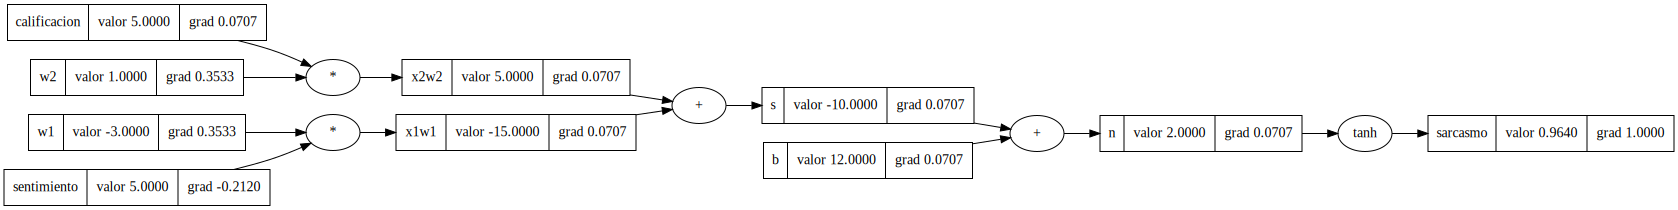

In [79]:
#entradas
sentimiento = Numero(5.0, etiqueta='sentimiento')
calificacion = Numero(5.0, etiqueta='calificacion')

# pesos (weights)
w1 = Numero(-3.0, etiqueta='w1')
w2 = Numero(1.0, etiqueta='w2')

# sesgo (bias)
b = Numero(12, etiqueta='b')

# x1*w1 + x2*w2 + b
x1w1 = sentimiento*w1; x1w1.etiqueta='x1w1'
x2w2 = calificacion*w2; x2w2.etiqueta='x2w2'
sumatoria = x1w1 + x2w2; sumatoria.etiqueta='s'
n = sumatoria + b; n.etiqueta='n'

# activación
sarcasmo = n.tanh(); sarcasmo.etiqueta= 'sarcasmo'

sarcasmo.propagar()

graficar(sarcasmo)

Por el momento, nuestros valores son aleatorios y todo funciona mal. La calificación y el sentimiento que asignamos son 5, pero la neurona indica que la reseña es sarcástica porque da ~1 como resultado. Al contrario, queremos que el sarcasmo sea 0 en este caso. Podemos optimizarla programáticamente ahora que ya conocemos la propagación hacia atrás.

Primero, crearemos la clase `Neurona` para crear una estructura como la anterior. Al pasar nuestras variables por la `Neurona`, obtendremos un `peso` y un `sesgo` por cada una. Hecho esto, realizaremos operaciones con el peso, el sesgo y las entradas para transformar las entradas y, con ello, obtengamos al final el resultado deseado. Por ejemplo: si mis entradas son 5 y 5 —como en nuestro ejemplo—, nosotros queremos encontrar unos pesos y sesgos tales que, multiplicados y sumados por 5 y 5, nos den como resultado un 0, puesto que 5 y 5 significa ausencia de sarcasmo en este caso. Al mismo tiempo, queremos que esos mismos pesos y sesgos, por ejemplo al ser multiplicados y sumados por un sentimiento de 5 y una calificación de 1, nos arrojen 1 como resultado, puesto que eso indicaría sarcasmo.

Para obtener como resultado una probabilidad de sarcasmo del 0 al 1, utilizaremos la función tangente hiperbólica, la cual es muy similar a las que vimos con anterioridad (sigmoide, ReLU, softmax): cuando nuestros valores la atraviesen, ella nos dará como resultado un valor del -1 al 1[^3].

In [80]:
import random

class Neurona:
  def __init__(self, nentradas):
    self.peso = [Numero(random.uniform(-1,1)) for i in range(nentradas)] # cada entrada tendrá un peso, que será un número aleatorio
    self.sesgo = Numero(random.uniform(-1,1)) # un sesgo con valor aleatorio del -1 al 1

  def __call__(self, x):
    # peso * x + sesgo
    activacion = sum((peso_i*x_i for peso_i, x_i in zip(self.peso, x)), self.sesgo) #multiplicamos, sumamos
    resultado = activacion.tanh() # aplicamos la función tangente hiperbólica
    return resultado

  def parametros(self):
    return self.peso + [self.sesgo]

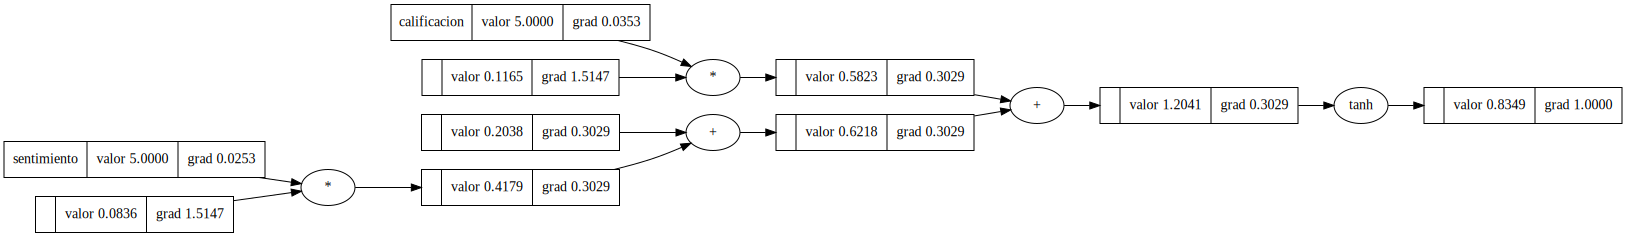

In [81]:
#entradas
sentimiento = Numero(5.0, etiqueta='sentimiento')
calificacion = Numero(5.0, etiqueta='calificacion')

N = Neurona(2) # creamos una neurona

neuron = N([sentimiento, calificacion]) # damos a las variables como valores de entrada

neuron.propagar()

graficar(neuron)

Nuestros pesos y sesgos tienen valores aleatorios, de manera que esto sigue sin funcionar. Para optimizarlos apropiadamente, será mejor crear una arquitectura más robusta. Entendámonos: será difícil que encontremos un par de pesos tales que, multiplicados por nuestras dos entradas, reflejen apropiadamente el sarcasmo como queremos. Si tenemos más pesos, probablemente sea más fácil encontrar una combinación de números que arroje los resultados que queremos.

Para ello, crearemos una red neuronal. Lo único que nos falta es una forma de conectar varias neuronas entre sí, así podremos tener más pesos y sesgos que entrenar, lo cual se traduce en mejor desempeño. 

Construiremos, pues, una «capa», que no es más que una forma programática de definir cuántas neuronas queremos para nuestras entradas, es decir, de generar una serie de neuronas; y finalmente conectaremos todo con un «perceptrón multicapa», que consiste en unir varias capas entre sí:

In [82]:
class Capa: # Layer
  def __init__(self, nentradas, nsalidas):
    self.neuronas = [Neurona(nentradas) for _ in range(nsalidas)]

  def __call__(self, x):
    resultado = [n(x) for n in self.neuronas]
    return resultado[0] if len(resultado) == 1 else resultado

  def parametros(self):
    return [parametro for n in self.neuronas for parametro in n.parametros()]

class MLP: # Perceptrón multicapa
  def __init__(self, nentrada, nsalidas):
    tamaño = [nentrada] + nsalidas
    self.capas = [Capa(tamaño[i], tamaño[i+1]) for i in range(len(nsalidas))]

  def __call__(self, x):
    for capa in self.capas:
      x = capa(x)
    return x

  def parametros(self):
    return [parametro for capa in self.capas for parametro in capa.parametros()]

Veamos una capa como ejemplo:

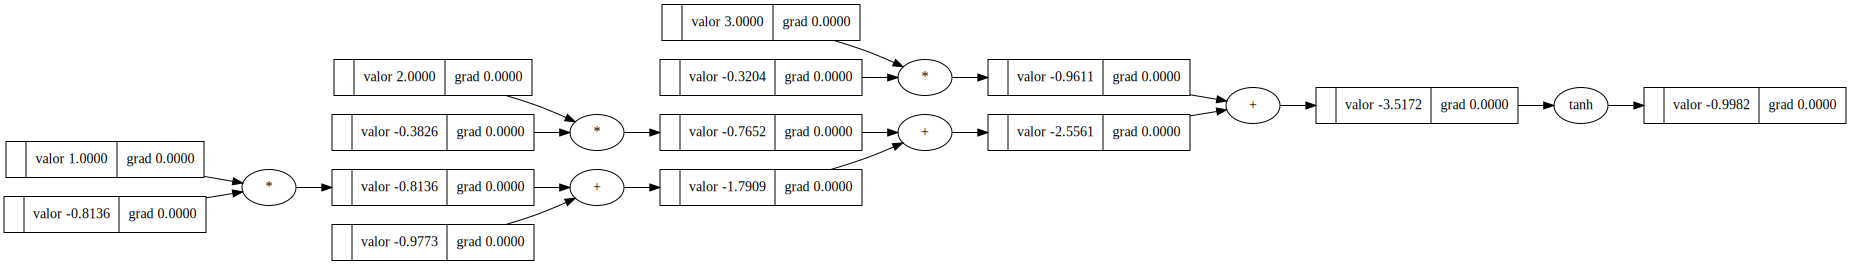

In [47]:
x = [1.0, 2.0, 3.0]
C = Capa(4, 1)
graficar(C(x))

Ahora veamos una red neuronal de la especie perceptrón multicapa:


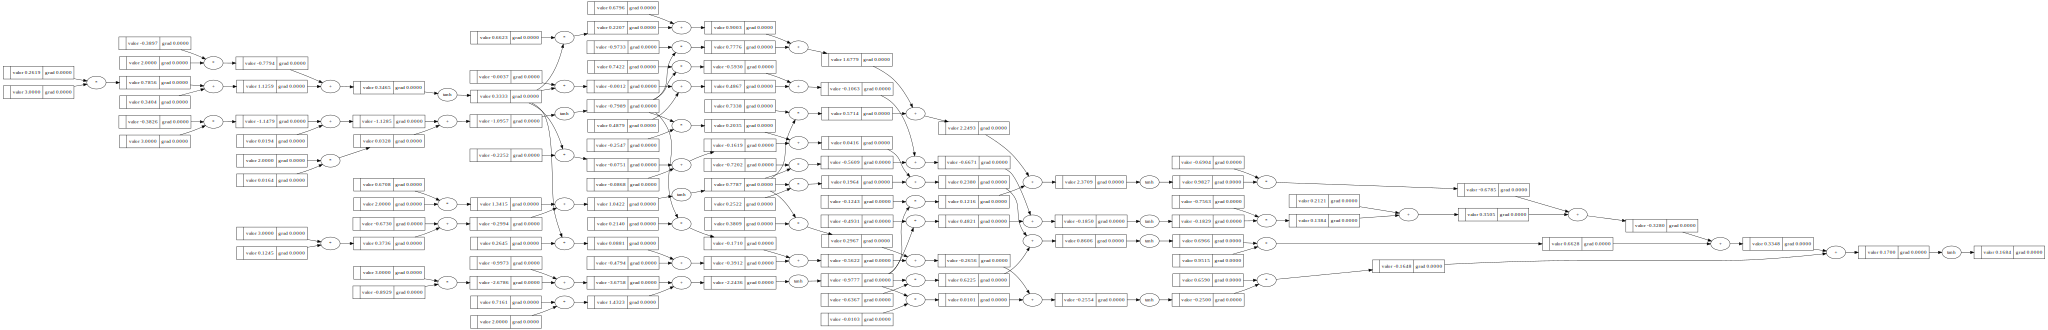

In [109]:
x = [3.0, 2.0]
RN = MLP(4, [4, 4, 1])

graficar(RN(x))

Como vemos, únicamente estamos interconectando y creando más neuronas para que nuestro modelo tenga más potencia. Al mismo tiempo, vemos que una neurona interconecta las entradas entre sí a través de pesos y sesgos. Los pesos y sesgos, además de realizar operaciones diferenciables (es decir, que podemos derivar), nos ayudarán a ir midiendo la relevancia de cada entrada para, con base en el gradiente, ajustarse en proporción a dicha relevancia. De igual forma, los pesos y sesgos articularán el patrón de números que en este caso necesitamos para convertir cada combinación de entradas en una probabilidad de sarcasmo.

Ahora manos a la obra. Daremos a nuestro modelo cuatro entradas de entrenamiento (es decir, serán ejemplos para que la red neuronal aprenda): cada entrada tendrá el sentimiento y la calificación asignada, así como el valor de sarcasmo objetivo que deseamos:

In [110]:
entradas = [
    [5.0, 5.0], # no sarcasmo
    [5.0, 1.0,], # sarcasmo
    [5.0, 2.0], # sarcasmo
    [4.0, 5.0], # no sarcasmo
]

objetivos = [0.0, 1.0, 1.0, 0.0]
predicciones = [RN(x) for x in entradas]
predicciones

[Valor=0.3669362864564352,
 Valor=0.06860246608538911,
 Valor=0.3213103120229461,
 Valor=0.3486194765977301]

Nuestras predicciones de sarcasmo fueron generadas con valores aleatorios, de manera que todas son erróneas. Ahora, debemos cuantificar qué tan alejadas están de su objetivo. Para ello, crearemos una función que mida la diferencia entre el objetivo y la predicción. Se trata de una simple resta, pero la elevaremos al cuadrado para obtener solo números positivos:

```{margin}
A esta función se le llama «error cuadrático medio» (o *mean squared error*, MSE en inglés); matemáticamente podemos definirla como $\frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2$. Es la «función de pérdida» (*loss function*) más simple que hay, pues solo estamos haciendo una resta entre objetivos y predicciones. Digamos que esta operación mide la distancia entre el objetivo y la predicción.
```

In [111]:
fn_perdida = [(pred - obj)**2 for pred, obj in zip(predicciones, objetivos)] #MSE
fn_perdida

[Valor=0.13464223831843908,
 Valor=0.8675013661822187,
 Valor=0.46061969256639074,
 Valor=0.1215355394632753]

Ahora, sumaremos los valores entre sí para obtener una sola cifra que nos permita cuantificar el desempeño general de nuestro modelo:

In [112]:
perdida = sum(fn_perdida)
perdida

Valor=1.5842988365303239

Luego, con base en la función de pérdida, haremos propagación hacia atrás: obtendremos los gradientes y, con ello, sabremos en qué dirección modificar nuestros pesos y sesgos para que la pérdida (o el error, o la distancia) sea 0, es decir, que nuestras predicciones sean idénticas a nuestros objetivos:

In [113]:
perdida.propagar()

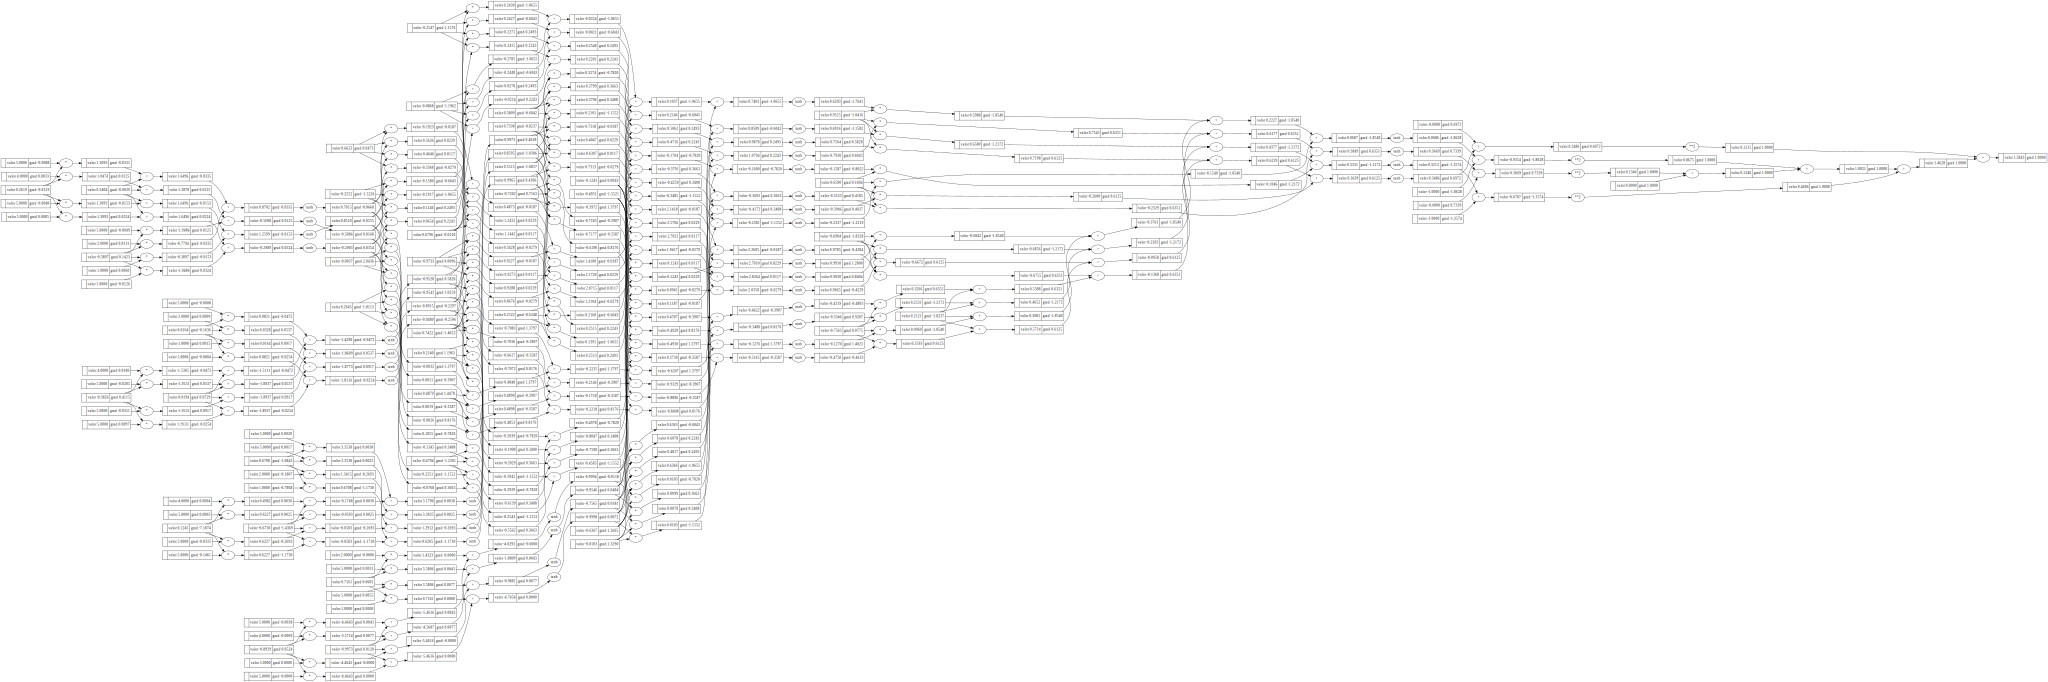

In [114]:
graficar(perdida)

Esto ya luce mucho más como una red neuronal. Calcular manualmente todos los gradientes sería engorroso; pero la programación nos permite apalancarnos de los algoritmos, las matemáticas y las computadoras para explotar su potencial a gran escala.

Echemos un vistazo a nuestros parámetros (o sea, pesos y sesgos):

In [115]:
RN.parametros()

[Valor=0.26185647542075774,
 Valor=-0.3897146431515013,
 Valor=-0.042130217416122884,
 Valor=0.716233520043825,
 Valor=0.34035823314645985,
 Valor=-0.38262186196333725,
 Valor=0.016423299964780647,
 Valor=-0.9183633316805504,
 Valor=-0.5763110561373717,
 Valor=0.019367922187966347,
 Valor=0.12454783116525658,
 Valor=0.6707556894941378,
 Valor=0.834698024121612,
 Valor=0.254042516410647,
 Valor=-0.6730022053225764,
 Valor=-0.8928621154187195,
 Valor=0.7161297325281775,
 Valor=0.09323426117937772,
 Valor=0.7985780052593621,
 Valor=-0.9972537117506883,
 Valor=-0.0037082550344191834,
 Valor=0.7422268948402582,
 Valor=-0.7202178129671104,
 Valor=-0.49309665896689103,
 Valor=0.48794442651441616,
 Valor=0.6622683039011021,
 Valor=-0.9732767794233275,
 Valor=0.7338007914809526,
 Valor=-0.12433377269499779,
 Valor=0.6796016177396522,
 Valor=-0.2252461785794555,
 Valor=-0.25469641100646667,
 Valor=0.25222074387643856,
 Valor=-0.636707051411459,
 Valor=-0.08679161950639269,
 Valor=0.2644632770583

Aunque para nosotros puedan no significar nada, lo cierto es que con base en el gradiente, nuestro modelo aprenderá a configurarlos de tal manera que representen un patrón cuya función será arrojar el resultado que nosotros queremos.

Ahora, dado que nuestra función de pérdida es positiva, queremos disminuirla. Si los gradientes nos indican la dirección en la que podemos aumentar el resultado de una función, entonces en este caso queremos ir en dirección opuesta al gradiente, pues eso tendría como resultado una disminución del resultado de la función. Para ello, sumaremos valor a las variables en el sentido **inverso** al gradiente (o, visto de otra forma, les restaremos valor según nos indique el gradiente). 

Para optimizar de mejor manera, haremos este mismo paso 30 veces, puesto que los cambios serán diminutos:

In [116]:
for k in range(30):

  # paso hacia delante
  preds = [RN(x) for x in entradas]
  perdida = sum([(pred - obj)**2 for pred, obj in zip(preds, objetivos)])

  # propagación hacia atrás, SGD
  for p in RN.parametros():
    p.grad = 0.0
  perdida.propagar()

  # actualizar
  for p in RN.parametros():
    p.valor += -0.07 * p.grad

  print(k, perdida.valor)

0 1.5842988365303239
1 1.2529558664951095
2 0.587216087017959
3 0.4191023147078547
4 0.5752410954325351
5 1.1191852453113773
6 1.784366523080085
7 1.652128457073363
8 1.224657076741451
9 0.26771058028648226
10 0.41855267707767796
11 0.707877061951523
12 0.15361704203665727
13 0.12954214337233716
14 0.12316318950192393
15 0.12964905806896287
16 0.1261090038316882
17 0.1336944727568814
18 0.11078544833502019
19 0.102441253791397
20 0.08312278356688153
21 0.0723339169867922
22 0.06107490601393822
23 0.053290880990198526
24 0.04659821460517871
25 0.04138965501323435
26 0.03716069258091919
27 0.03363478739730862
28 0.030798690241934046
29 0.02833061619126015


Al parecer, nuestra función de pérdida disminuyó casi a cero. Comprobemos que nuestras predicciones ahora sean más similares a nuestros objetivos:

In [117]:
preds

[Valor=0.1016585786227638,
 Valor=0.9171470012496584,
 Valor=0.8984522443847082,
 Valor=0.02862836899357634]

In [118]:
objetivos

[0.0, 1.0, 1.0, 0.0]

En efecto, nuestro modelo ya es mucho más apto ahora que antes para detectar sarcasmo. ¿Qué tal si hacemos un test con una nueva calificación? El sentimiento será de 5 y la calificación 1.5:

In [119]:
test = [5.0, 1.5]

prediccion = RN(test)
prediccion

Valor=0.9022088768249822

Nuestra red neuronal considera que existe un ~90% de probabilidad de que sea sarcasmo. Nada mal.

[^1]: El nombre técnico de esta derivada es «derivada parcial», puesto que la función $c$ tiene dos variables y solo estamos considerando la derivada con respecto a una variable. En esencia, si tenemos solo una variable en la función, entonces hablamos de derivada; pero si tenemos más de una variable y estimamos la derivada solo con respecto a una variable, entonces hablamos de derivada parcial.

[^2]: A operar con varias funciones concatenadas entre sí se le denomina «composición de funciones». La composición o concatenación de funciones consiste en tomar la salida de una función para pasarla como entrada de otra, y así consecutivamente. Según el esquema de nuestra primera lección, podríamos expresarlo como $x \mapsto f(x) \mapsto g(f(x))$, etcétera. Una visualización luciría más o menos así: <img src='https://upload.wikimedia.org/wikipedia/commons/6/65/FunctionMachinesComposition.svg' width=300>

[^3]: La elección de una función no lineal (tanh, ReLU, etc.) es una cuestión técnica que tiene que ver con el problema a tratar y con cómo fluyen a través de ellas los gradientes. Dado que nuestro problema es relativamente simple, podemos usar cualquiera. Por otro lado, aunque suene extraño que nuestro modelo pueda arrojar probabilidades negativas, eso no sucederá siempre y cuando nuestras entradas estén en el rango de valores que seleccionamos para el entrenamiento (*i. e.*, 0 a 5 en ambas variables). Si, por ejemplo, dijéramos que la calificación es 30 y el sentimiento 20, nuestro modelo interpretaría esto como una probabilidad de sarcasmo negativa. Es obligado mencionar [el paper](https://cds.cern.ch/record/154856/files/pre-27827.pdf/) en el que el gran Feynman explica qué sentido tiene hablar de probabilidades negativas.